# Notebook to Visualize IBTrACS (International Best Track Archive for Climate Stewardship) Hurricane Data (1980-2025)

In [1]:
import warnings # to avoid unwanted warnings
warnings.filterwarnings("ignore")

### Importing Necessary Modules

In [4]:
import xarray as xr # for handling labeled multi-dimensional arrays
import numpy as np # for numerical operations on arrays and matrices
import pandas as pd # for data manipulation and analysis, especially for tabular data

In [6]:
import cartopy # for geospatial data visualization and map projections
import cartopy.crs as ccrs # coordinate reference system module for defining map projections
import cartopy.feature as cfeature # for adding geographical features like land, oceans, etc., to maps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER # for customizing longitude and latitude labels on map gridlines

In [8]:
import matplotlib.pyplot as plt # for creating plots and visualizations
from matplotlib import cm #  for colormap handling
import matplotlib.ticker as mticker #  for customizing axis ticks and labels
import cmaps #  for additional colormaps

import time # handling time-related operations, such as measuring execution time
from datetime import datetime # for working with dates and times
import sys # for system-specific parameters and functions, e.g., accessing command-line arguments

In [10]:
from scipy import stats # stats module for statistical functions and analysis
import seaborn as sns # for enhanced statistical data visualization
import string # for generating labels or annotations

In [12]:
import statsmodels.api as sm # for statistical modeling, such as regression analysis

In [13]:
import sklearn.metrics as skmet # for evaluating machine learning models, e.g., accuracy or error metrics

import requests # for requesting the web to download datasets

### Download the IBTrACS dataset 

In [ ]:
url = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.since1980.list.v04r01.csv"
response = requests.get(url)
with open("ibtracs.since1980.list.v04r01.csv", "wb") as file:
    file.write(response.content)

### Get the User Inputs.

In [16]:
n = 4 #gridsize
year0 = 1990  #start year (1980 or after)
year1 = 2024 #end year
thresh = 10 #threshold for number of years with a TC in a cell needed before calculating trends
gridsize = n

# choose whether you take the mean intensity in a grid cell or mean max intensity
meantype = 'mean'
#meantype = 'max'

In [18]:
def get_cis(x,y):
    boot_ci_temp = []
    R = 100  # set to be large enough to be replicable
    for i in range(R):

        ##Create a new dataset resampled with replacement directly from dataset
        idx = np.random.choice(np.arange(len(x)), size=len(x))  #random indices <=N
        Xboot = x[idx]-np.mean(x[idx])  #no Y-INTERCEPT this time
        yboot = y[idx]-np.mean(y[idx])

        # Re-fit the linear regression model and map back to beta (dont care about intercept)
        boot_model = sm.OLS(yboot, Xboot).fit()  #ONLY PARAMETER IS THE SLOPE: y=b*x (no intercept by definition)
        boot_ci_temp.append(boot_model.params)
        # predictions = boot_model.get_prediction()
        # confidence_intervals = predictions.conf_int()

    #extract CI on slopes no interecept
    ci_slopelow, ci_slopehigh = np.percentile(boot_ci_temp, 2.5, axis=0), np.percentile(boot_ci_temp, 97.5, axis=0)
    return ci_slopelow,ci_slopehigh

### Read the Downloaded IBTrACS file

In [20]:
ib_df = pd.read_csv('ibtracs.since1980.list.v04r01.csv',keep_default_na=False)

In [117]:
ib_df

SID SEASON NUMBER BASIN SUBBASIN     NAME  \
0                       Year                                  
1       1980001S13173   1980      1    SP       MM     PENI   
2       1980001S13173   1980      1    SP       MM     PENI   
3       1980001S13173   1980      1    SP       MM     PENI   
4       1980001S13173   1980      1    SP       MM     PENI   
...               ...    ...    ...   ...      ...      ...   
299817  2025108S11140   2025     24    SI       WA  UNNAMED   
299818  2025108S11140   2025     24    SI       WA  UNNAMED   
299819  2025108S11140   2025     24    SI       WA  UNNAMED   
299820  2025108S11140   2025     24    SI       WA  UNNAMED   
299821  2025108S11140   2025     24    SI       WA  UNNAMED   

                   ISO_TIME NATURE            LAT           LON  ...  \
0                                   degrees_north  degrees_east  ...   
1       1980-01-01 00:00:00     TS          -12.5         172.5  ...   
2       1980-01-01 03:00:00     TS          -12.2         172.4  ...   
3       1980-01-01 06:00:00     TS          -11.9         172.4  ...   
4       1980-01-01 09:00:00     TS          -11.7         172.4  ...   
...                     ...    ...            ...           ...  ...   
299817  2025-04-22 00:00:00     NR          -10.4         134.1  ...   
299818  2025-04-22 03:00:00     NR          -10.3         134.0  ...   
299819  2025-04-22 06:00:00     NR          -10.3         134.0  ...   
299820  2025-04-22 09:00:00     NR          -10.2         133.7  ...   
299821  2025-04-22 12:00:00     NR          -10.0         133.2  ...   

       BOM_GUST_PER REUNION_GUST REUNION_GUST_PER USA_SEAHGT USA_SEARAD_NE  \
0            second          kts           second         ft         nmile   
1                                                                            
2                                                                            
3                                                                            
4                                                                            
...             ...          ...              ...        ...           ...   
299817                                                                       
299818                                                                       
299819                                                                       
299820                                                                       
299821                                                                       

       USA_SEARAD_SE USA_SEARAD_SW USA_SEARAD_NW STORM_SPEED STORM_DIR  
0              nmile         nmile         nmile         kts   degrees  
1                                                          6       350  
2                                                          6       350  
3                                                          5       360  
4                                                          4        10  
...              ...           ...           ...         ...       ...  
299817                                                     7       295  
299818                                                     1       315  
299819                                                     3       295  
299820                                                     8       290  
299821                                                    11       290  

[299822 rows x 174 columns]

In [131]:
track_year = ib_df[ib_df.SEASON==year].to_xarray()

In [133]:
track_year

<xarray.Dataset> Size: 11MB
Dimensions:           (index: 8090)
Coordinates:
  * index             (index) int64 65kB 62712 62713 62714 ... 75224 75225 75226
Data variables: (12/174)
    SID               (index) object 65kB '1989189S07088' ... '1990348N04087'
    SEASON            (index) object 65kB 1990 1990 1990 1990 ... 1990 1990 1990
    NUMBER            (index) object 65kB 49 49 49 49 49 ... 116 116 116 116 116
    BASIN             (index) object 65kB 'SI' 'SI' 'SI' 'SI' ... 'NI' 'NI' 'NI'
    SUBBASIN          (index) object 65kB 'MM' 'MM' 'MM' 'MM' ... 'BB' 'BB' 'BB'
    NAME              (index) object 65kB 'UNNAMED' 'UNNAMED' ... 'UNNAMED'
    ...                ...
    USA_SEARAD_NE     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SE     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SW     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_NW     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    STORM_SPEED       (index) object 65kB '6' '6' '6' '5' '4' '3' ... 9 10 9 9 9
    STORM_DIR         (index) object 65kB '305' '300' '290' '280' ... 65 70 75

## Creating Hurricane Track Density - IBTrACS

In [32]:
st = time.time()

# creates a netcdf file of track density - used for visualiziation & calculating weighted zonal means

td_list = []

for year in np.arange(year0,year1+1):
    track_year = ib_df[ib_df.SEASON==year].to_xarray()

    gridsize = n
    grid = np.zeros((int(180/gridsize),int(360/gridsize)))
    for i in track_year.index.values:
        track_point = track_year.sel(index=i)
        lon_g = round(track_point.LON.values/gridsize)
        lat_g = round((track_point.LAT.values+90)/gridsize)
        grid[lat_g,lon_g]+=1


    td = xr.DataArray(grid,dims=('lat','lon'))
    td.coords['lat'] = (td.coords['lat']*gridsize - 90)
    td.coords['lon'] = (td.coords['lon']*gridsize)
    td_list.append(td.assign_coords(year=year))

    et = time.time()
    print(f'{year}: {round((et-st)/60,3)} mins')


xr.concat((a for a in td_list),'year').to_netcdf(f'ibtracs-trackdensity-{gridsize}x{gridsize}_{year0}-{year1}.nc')

1990: 0.712 mins
1991: 1.319 mins
1992: 2.078 mins
1993: 2.709 mins
1994: 3.442 mins
1995: 4.037 mins
1996: 4.795 mins
1997: 5.637 mins
1998: 6.264 mins
1999: 6.879 mins
2000: 7.494 mins
2001: 8.025 mins
2002: 8.555 mins
2003: 9.169 mins
2004: 9.804 mins
2005: 10.449 mins
2006: 10.987 mins
2007: 11.455 mins
2008: 12.026 mins
2009: 12.564 mins
2010: 13.027 mins
2011: 13.545 mins
2012: 14.1 mins
2013: 14.638 mins
2014: 15.206 mins
2015: 15.847 mins
2016: 16.39 mins
2017: 16.91 mins
2018: 17.568 mins
2019: 18.298 mins
2020: 18.858 mins
2021: 19.465 mins
2022: 20.001 mins
2023: 20.592 mins
2024: 21.043 mins


## creation of track density file for hurricanes greater than 64 knots or 32 m/s

In [36]:
# track density for hurricanes that are greater than 64 knots

# Hurricane threshold (64 knots)
HURRICANE_THRESHOLD = 64

st = time.time()

td_list = []

for year in np.arange(year0, year1 + 1):
    track_year = ib_df[ib_df.SEASON == year].to_xarray()

    gridsize = n
    grid = np.zeros((int(180/gridsize), int(360/gridsize)))
    for i in track_year.index.values:
        track_point = track_year.sel(index=i)
        intensity = track_point.WMO_WIND
        if intensity == ' ':
            intensity = float('NaN')
        else:
            intensity = float(intensity)
            if intensity >= HURRICANE_THRESHOLD:
                lon_g = round(track_point.LON.values/gridsize)
                lat_g = round((track_point.LAT.values + 90)/gridsize)
                grid[lat_g, lon_g] += 1

    td = xr.DataArray(grid, dims=('lat', 'lon'))
    td.coords['lat'] = (td.coords['lat'] * gridsize - 90)
    td.coords['lon'] = (td.coords['lon'] * gridsize)
    td_list.append(td.assign_coords(year=year))

    et = time.time()
    print(f'{year}: {round((et - st) / 60, 3)} mins')

xr.concat((a for a in td_list), 'year').to_netcdf(f'ibtracs-trackdensity-{gridsize}x{gridsize}_{year0}-{year1}_64.nc')

1990: 0.761 mins
1991: 1.351 mins
1992: 2.119 mins
1993: 2.756 mins
1994: 3.501 mins
1995: 4.11 mins
1996: 4.916 mins
1997: 5.775 mins
1998: 6.38 mins
1999: 6.958 mins
2000: 7.571 mins
2001: 8.104 mins
2002: 8.641 mins
2003: 9.259 mins
2004: 9.9 mins
2005: 10.552 mins
2006: 11.097 mins
2007: 11.57 mins
2008: 12.139 mins
2009: 12.68 mins
2010: 13.152 mins
2011: 13.68 mins
2012: 14.258 mins
2013: 14.814 mins
2014: 15.394 mins
2015: 16.052 mins
2016: 16.606 mins
2017: 17.127 mins
2018: 17.787 mins
2019: 18.448 mins
2020: 19.02 mins
2021: 19.642 mins
2022: 20.189 mins
2023: 20.781 mins
2024: 21.239 mins


## this plots the "normal" track density for all the hurricanes 

Text(0.5, 1.0, 'Mean 4x4$^\\circ$ Track Density Trend (Theil-Sen) [tracks/year] 1980-2024')

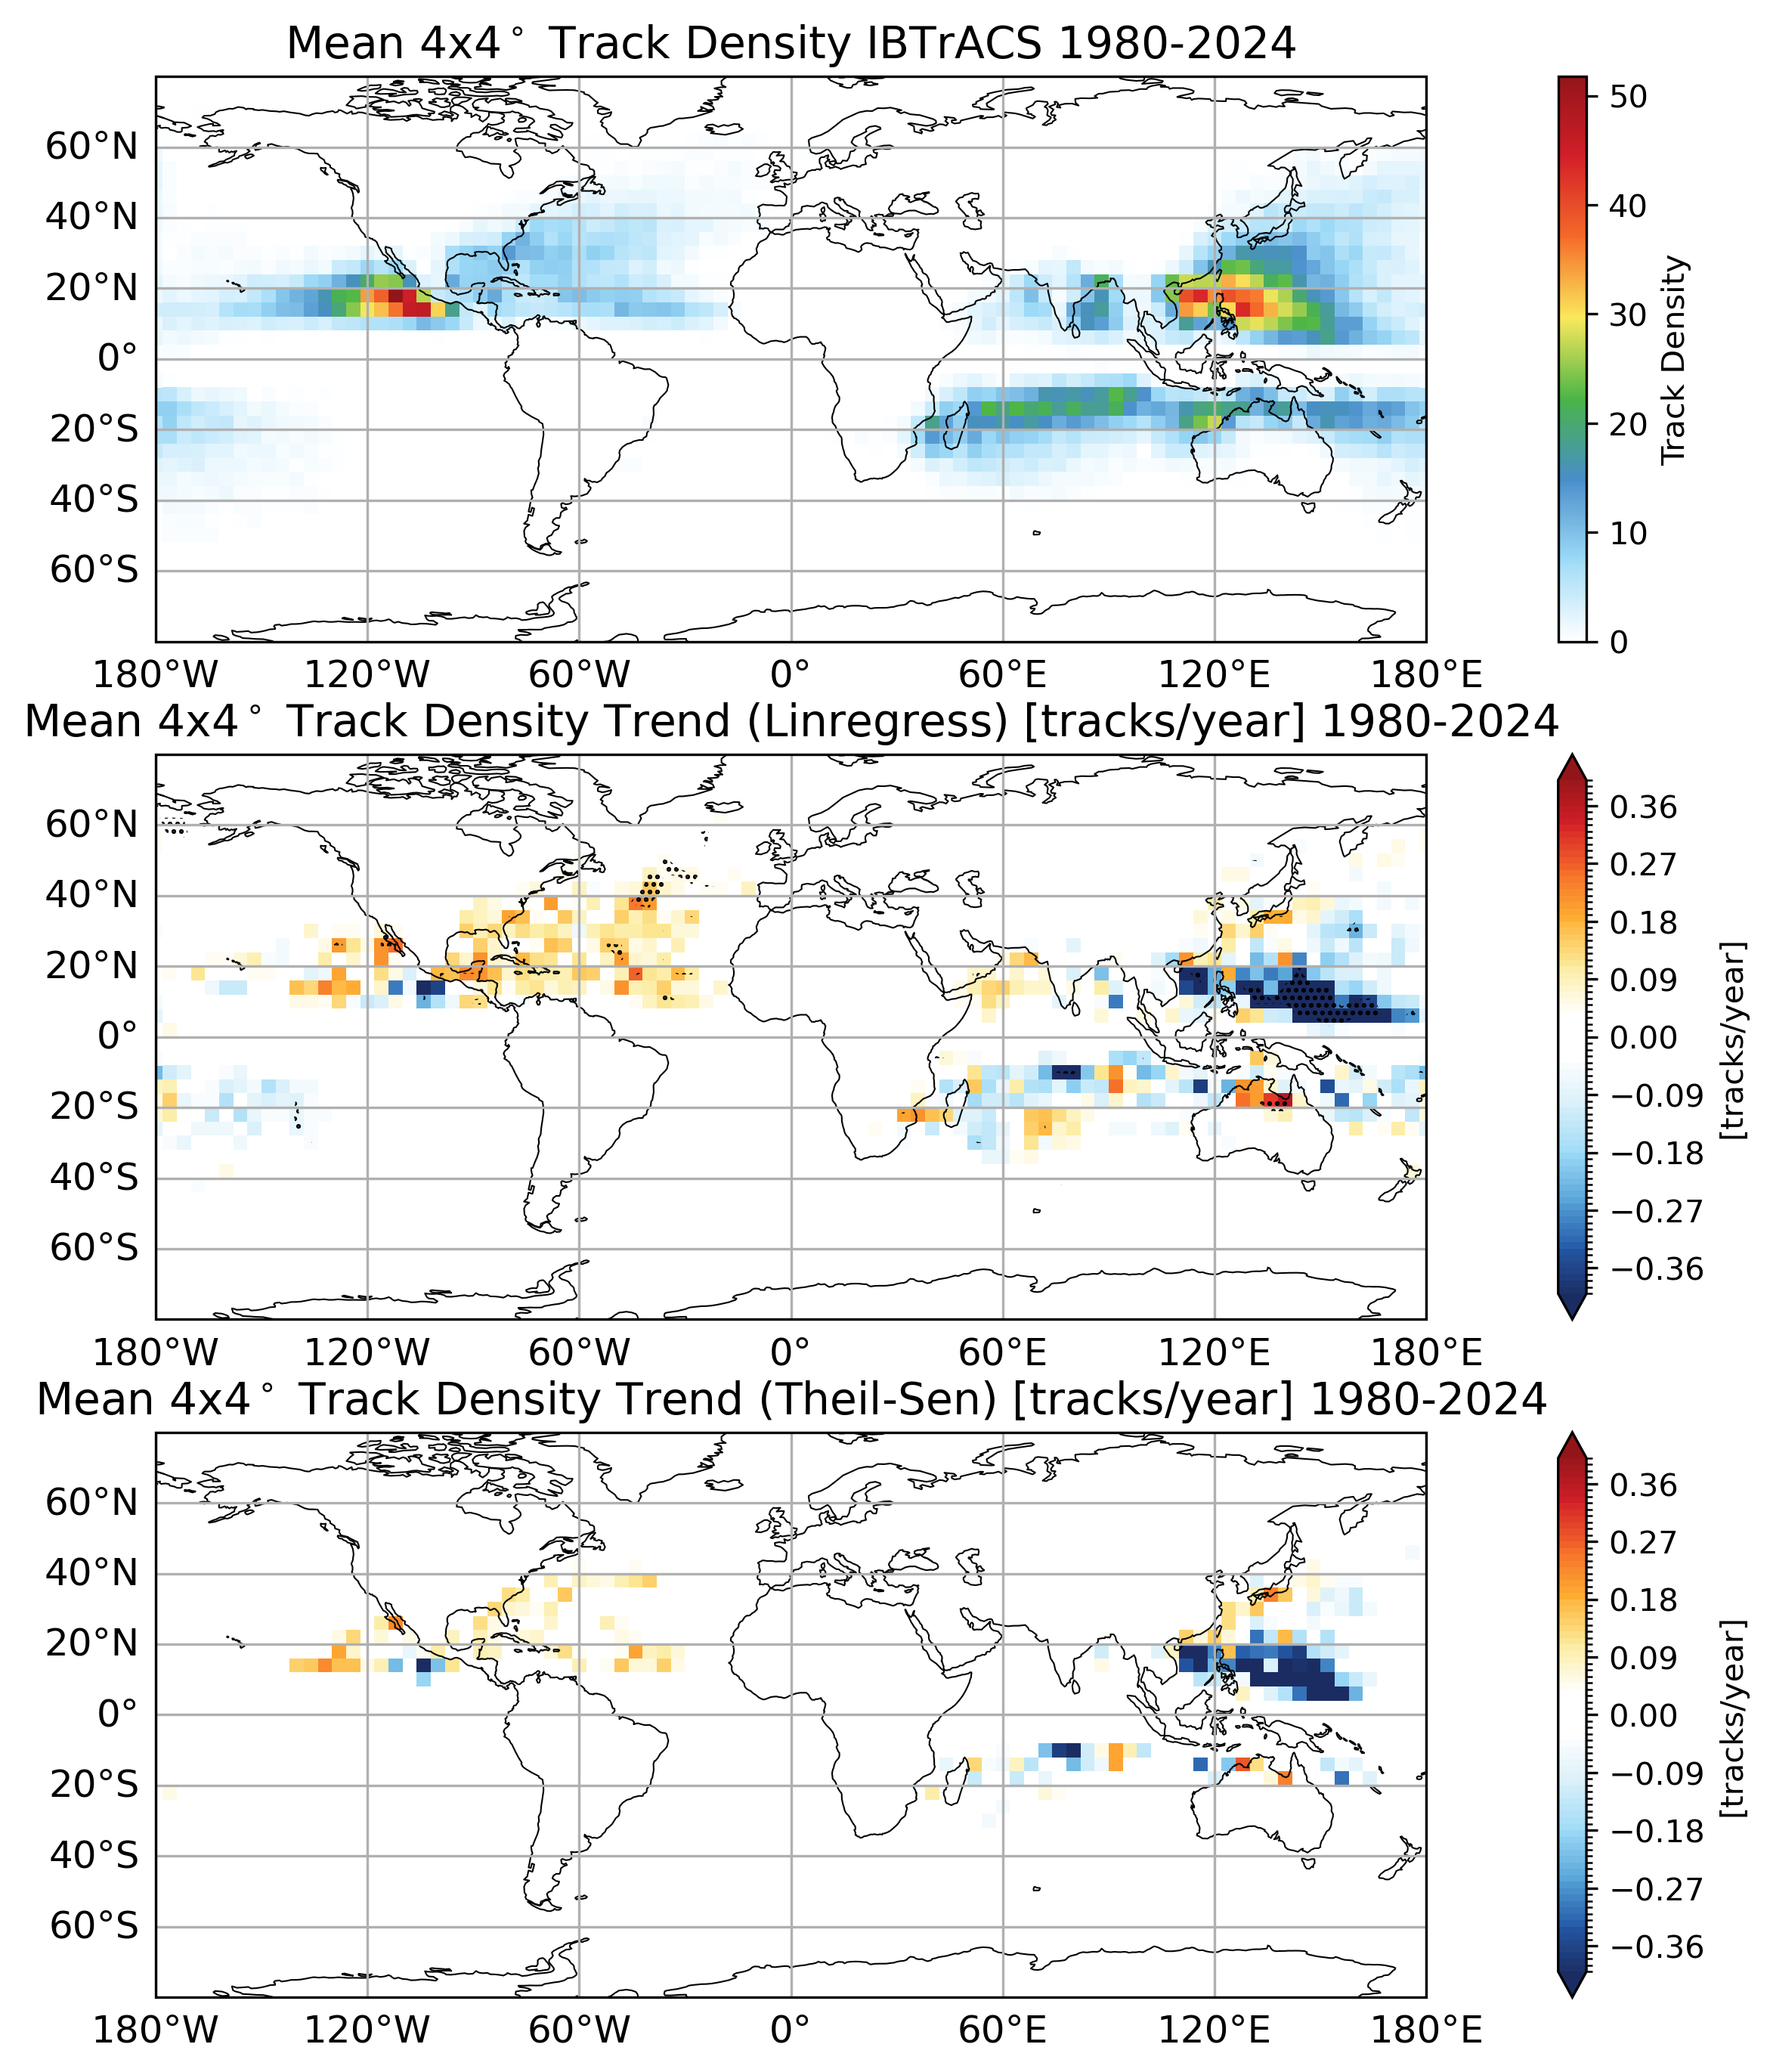

In [21]:
# plots mean density & trends

td = xr.open_dataarray(f'ibtracs-trackdensity-{gridsize}x{gridsize}_{year0}-{year1}.nc')

pval_list = []
slope_list = []
slope_th_list = []
slope_high_list = []
slope_low_list = []

for lat in td.lat:
    for lon in td.lon:
        td_grid = td.sel(lat=lat,lon=lon).dropna('year')
        if len(td_grid)<thresh:
            pval_list.append(float('nan'))
            slope_list.append(float('nan'))
            slope_th_list.append(float('nan'))
            slope_low_list.append(float('nan'))
            slope_high_list.append(float('nan'))
            continue
        slope,intercept,rval,pval,std_err = stats.linregress(td_grid.year.values,td_grid.values)
        slope_th, intercept, low_slope, high_slope = stats.theilslopes(td_grid.values,td_grid.year.values)

        pval_list.append(float(pval))
        slope_list.append(float(slope))
        slope_th_list.append(float(slope_th))
        slope_high_list.append(float(high_slope))
        slope_low_list.append(float(low_slope))

pval_grid = xr.DataArray(np.array(pval_list).reshape(len(td.lat),len(td.lon)),
                        coords={'lat':td.lat.values,'lon':td.lon.values})

slope_grid = xr.DataArray(np.array(slope_list).reshape(len(td.lat),len(td.lon)),
                        coords={'lat':td.lat.values,'lon':td.lon.values})
slope_th_grid = xr.DataArray(np.array(slope_th_list).reshape(len(td.lat),len(td.lon)),
                        coords={'lat':td.lat.values,'lon':td.lon.values})
slope_high_grid = xr.DataArray(np.array(slope_high_list).reshape(len(td.lat),len(td.lon)),
                        coords={'lat':td.lat.values,'lon':td.lon.values})
slope_low_grid = xr.DataArray(np.array(slope_low_list).reshape(len(td.lat),len(td.lon)),
                        coords={'lat':td.lat.values,'lon':td.lon.values})

fig = plt.figure(figsize=(15,11),dpi=300,)

ax = fig.add_subplot(3,1,1,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

td.mean('year').plot(cmap=cmaps.WhiteBlueGreenYellowRed, cbar_kwargs={'label': 'Track Density'}
 #                                           levels=np.arange(0,16,1),
                    )
plt.ylim(-80,80)
plt.title(f'Mean {n}x{n}$^\circ$ Track Density IBTrACS {year0}-{year1}',fontsize=14)


ax = fig.add_subplot(3,1,2,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_grid.plot(cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-.4,.401,0.01), cbar_kwargs={'label': '[tracks/year]'}, extend='both')
cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
plt.title(f'Mean {n}x{n}$^\circ$ Track Density Trend (Linregress) [tracks/year] {year0}-{year1}',fontsize=14)

ax = fig.add_subplot(3,1,3,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_th_grid.plot(cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-.4,.401,0.01), cbar_kwargs={'label': '[tracks/year]'}, extend='both')

plt.ylim(-80,80)
plt.title(f'Mean {n}x{n}$^\circ$ Track Density Trend (Theil-Sen) [tracks/year] {year0}-{year1}',fontsize=14)

## Creating Hurricane TC (Tropical Cyclone Intensity) - IBTrACS

## This is for Pmin

In [46]:
# pressure
st = time.time()

tint_list = []

for year in np.arange(year0, year1 + 1):
    track_year = ib_df[ib_df.SEASON == year].to_xarray()

    gridsize = n
    td_list = []
    for i in track_year.index.values:
        grid = np.zeros((int(180 / gridsize), int(360 / gridsize)))
        track_point = track_year.sel(index=i)
        lon_g = round(track_point.LON.values / gridsize)
        lat_g = round((track_point.LAT.values + 90) / gridsize)
        pressure = track_point.WMO_PRES
        if pressure == ' ':
            pressure = float('NaN')
        else:
            pressure = float(pressure)  # Convert string to float (mb)
            grid[lat_g, lon_g] = pressure  

        td = xr.DataArray(grid, dims=('lat', 'lon'))
        td.coords['lat'] = (td.coords['lat'] * gridsize - 90)
        td.coords['lon'] = (td.coords['lon'] * gridsize)
        td_list.append(td)

    tint_year = xr.concat((a for a in td_list), 'point')
    if meantype == 'max':
        tint_year = tint_year.where(tint_year > 0).max('point').assign_coords(year=year)
    elif meantype == 'mean':
        tint_year = tint_year.where(tint_year > 0).mean('point').assign_coords(year=year)

    tint_list.append(tint_year)

    et = time.time()
    print(f'{year}: {round((et - st) / 60, 3)} mins')

# Save the output to NetCDF
if meantype == 'max':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-maxpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')
elif meantype == 'mean':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-meanpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')

1990: 1.408 mins
1991: 2.394 mins
1992: 3.679 mins
1993: 4.731 mins
1994: 5.986 mins
1995: 6.983 mins
1996: 8.265 mins
1997: 9.714 mins
1998: 14.723 mins
1999: 15.844 mins
2000: 16.909 mins
2001: 17.809 mins
2002: 18.701 mins
2003: 19.744 mins
2004: 20.966 mins
2005: 22.159 mins
2006: 23.149 mins
2007: 23.996 mins
2008: 25.092 mins
2009: 26.095 mins
2010: 26.968 mins
2011: 27.928 mins
2012: 28.934 mins
2013: 29.968 mins
2014: 30.926 mins
2015: 32.004 mins
2016: 32.922 mins
2017: 33.82 mins
2018: 34.932 mins
2019: 36.012 mins
2020: 36.955 mins
2021: 38.016 mins
2022: 38.955 mins
2023: 40.009 mins
2024: 40.818 mins


## This is for Wind Intensity

In [38]:
st = time.time()

tint_list = []

for year in np.arange(year0, year1 + 1):
    track_year = ib_df[ib_df.SEASON == year].to_xarray()

    gridsize = n
    td_list = []
    for i in track_year.index.values:
        grid = np.zeros((int(180 / gridsize), int(360 / gridsize)))
        track_point = track_year.sel(index=i)
        lon_g = round(track_point.LON.values / gridsize)
        lat_g = round((track_point.LAT.values + 90) / gridsize)
        intensity = track_point.WMO_WIND
        if intensity == ' ':
            intensity = float('NaN')
        else:
            intensity = float(intensity)  # Convert string to float (already in m/s)
            grid[lat_g, lon_g] = intensity  # Keep intensity in m/s

        td = xr.DataArray(grid, dims=('lat', 'lon'))
        td.coords['lat'] = (td.coords['lat'] * gridsize - 90)
        td.coords['lon'] = (td.coords['lon'] * gridsize)
        td_list.append(td)

    tint_year = xr.concat((a for a in td_list), 'point')
    if meantype == 'max':
        tint_year = tint_year.where(tint_year > 0).max('point').assign_coords(year=year)
    elif meantype == 'mean':
        tint_year = tint_year.where(tint_year > 0).mean('point').assign_coords(year=year)

    tint_list.append(tint_year)

    et = time.time()
    print(f'{year}: {round((et - st) / 60, 3)} mins')

# Save the output to NetCDF
if meantype == 'max':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-maxint-{gridsize}x{gridsize}_{year0}-{year1}.nc')
elif meantype == 'mean':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-meanint-{gridsize}x{gridsize}_{year0}-{year1}.nc')

2000: 1.163 mins
2001: 2.165 mins
2002: 3.13 mins
2003: 4.28 mins
2004: 5.581 mins
2005: 6.827 mins
2006: 7.772 mins
2007: 8.586 mins
2008: 9.57 mins
2009: 10.508 mins
2010: 11.345 mins
2011: 12.248 mins
2012: 13.215 mins
2013: 14.17 mins
2014: 15.267 mins
2015: 16.686 mins
2016: 17.791 mins
2017: 18.711 mins
2018: 19.957 mins
2019: 21.383 mins
2020: 22.63 mins
2021: 23.943 mins
2022: 25.087 mins
2023: 26.351 mins
2024: 27.317 mins


## This is for Wind Intensity greater than 64 knots

In [38]:
# Hurricane threshold (64 knots)
HURRICANE_THRESHOLD = 64

# Process data, only including hurricanes (>= 64 knots)
st = time.time()

tint_list = []

for year in np.arange(year0, year1 + 1):
    track_year = ib_df[ib_df.SEASON == year].to_xarray()

    gridsize = n
    td_list = []
    for i in track_year.index.values:
        grid = np.zeros((int(180 / gridsize), int(360 / gridsize)))
        track_point = track_year.sel(index=i)
        lon_g = round(track_point.LON.values / gridsize)
        lat_g = round((track_point.LAT.values + 90) / gridsize)
        intensity = track_point.WMO_WIND
        if intensity == ' ':
            intensity = float('NaN')
        else:
            intensity = float(intensity)  # Convert string to float (already in m/s)
            if intensity >= HURRICANE_THRESHOLD:  # Check hurricane threshold in m/s
                grid[lat_g, lon_g] = intensity  # Keep intensity in m/s

        td = xr.DataArray(grid, dims=('lat', 'lon'))
        td.coords['lat'] = (td.coords['lat'] * gridsize - 90)
        td.coords['lon'] = (td.coords['lon'] * gridsize)
        td_list.append(td)

    tint_year = xr.concat((a for a in td_list), 'point')
    if meantype == 'max':
        tint_year = tint_year.where(tint_year > 0).max('point').assign_coords(year=year)
    elif meantype == 'mean':
        tint_year = tint_year.where(tint_year > 0).mean('point').assign_coords(year=year)

    tint_list.append(tint_year)

    et = time.time()
    print(f'{year}: {round((et - st) / 60, 3)} mins')

# Save the output to NetCDF
if meantype == 'max':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-maxint-{gridsize}x{gridsize}_{year0}-{year1}_64.nc')
elif meantype == 'mean':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-meanint-{gridsize}x{gridsize}_{year0}-{year1}_64.nc')

1990: 1.248 mins
1991: 2.246 mins
1992: 3.674 mins
1993: 4.775 mins
1994: 6.085 mins
1995: 7.124 mins
1996: 8.466 mins
1997: 9.951 mins
1998: 11.029 mins
1999: 12.093 mins
2000: 13.212 mins
2001: 14.136 mins
2002: 15.077 mins
2003: 16.133 mins
2004: 17.236 mins
2005: 18.451 mins
2006: 19.389 mins
2007: 20.263 mins
2008: 21.291 mins
2009: 22.378 mins
2010: 23.277 mins
2011: 24.245 mins
2012: 25.282 mins
2013: 26.308 mins
2014: 27.395 mins
2015: 28.605 mins
2016: 29.628 mins
2017: 30.589 mins
2018: 31.821 mins
2019: 33.06 mins
2020: 34.121 mins
2021: 35.288 mins
2022: 36.296 mins
2023: 37.383 mins
2024: 38.227 mins


### Calculation of the trends (should be the same for both wind speed and pressure)

In [50]:
# calculates intensity trends for spatial maps

st = time.time()

if meantype == 'max':
  tint = xr.open_dataarray(f'ibtracs-maxpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')
elif meantype == 'mean':
  tint = xr.open_dataarray(f'ibtracs-meanpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')


pval_list = []
slope_list = []
slope_th_list = []
slope_high_list = []
slope_low_list = []

for lat in tint.lat:
    for lon in tint.lon:
        tint_grid = tint.sel(lat=lat,lon=lon).dropna('year')
        if len(tint_grid)<thresh:
            pval_list.append(float('nan'))
            slope_list.append(float('nan'))
            slope_th_list.append(float('nan'))
            slope_low_list.append(float('nan'))
            slope_high_list.append(float('nan'))
            continue
        slope,intercept,rval,pval,std_err = stats.linregress(tint_grid.year.values,tint_grid.values)
        slope_th, intercept, low_slope, high_slope = stats.theilslopes(tint_grid.values,tint_grid.year.values)

        pval_list.append(float(pval))
        slope_list.append(float(slope))
        slope_th_list.append(float(slope_th))
        slope_high_list.append(float(high_slope))
        slope_low_list.append(float(low_slope))

pval_grid = xr.DataArray(np.array(pval_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})

slope_grid = xr.DataArray(np.array(slope_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})
slope_th_grid = xr.DataArray(np.array(slope_th_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})
slope_high_grid = xr.DataArray(np.array(slope_high_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})
slope_low_grid = xr.DataArray(np.array(slope_low_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})


et = time.time()
elapsed_time = et - st
print(elapsed_time/60, 'mins')

0.2588262597719828 mins


## Visualizing the TC Intensity Grid File - IBTrACS

### This Plots WMO_WIND or wind intensity

In [ ]:
# spatial maps of intensity trends
if meantype == 'mean':
  tint = xr.open_dataarray(f'ibtracs-meanint-{gridsize}x{gridsize}_{year0}-{year1}.nc')*0.514444 # converts to m/s instead of kts
if meantype == 'max':
  tint = xr.open_dataarray(f'ibtracs-maxint-{gridsize}x{gridsize}_{year0}-{year1}.nc')*0.514444


fig = plt.figure(figsize=(15,11),dpi=300,)

ax = fig.add_subplot(3,1,1,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

tint.mean('year').plot(cmap=cmaps.WhiteBlueGreenYellowRed, cbar_kwargs={'label': 'Wind Intensity [m/s]'}
 #                       levels=np.arange(32,74,3.0),
                      )
plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Intensity IBTrACS {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC intensity {year0}-{year1}',fontsize=14)


ax = fig.add_subplot(3,1,2,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_grid.plot(
                levels=np.arange(-1.5,1.55,0.05), extend='both', cbar_kwargs={'label': 'Wind Intensity Trend [m/s/year]'}
               )
cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Intensity Trend (Linregress) [m/s/year] {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Intensity Trend (Linregress) [m/s/year] {year0}-{year1}',fontsize=14)

ax = fig.add_subplot(3,1,3,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_th_grid.plot(
                levels=np.arange(-1.5,1.55,0.05), extend='both' ,cbar_kwargs={'label': 'Wind Intensity Trend [m/s/year]'}
               )
# cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Intensity Trend (Theil-Sen) [m/s/year] {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Intensity Trend (Theil-Sen) [m/s/year] {year0}-{year1}',fontsize=14)


### This Plots WMO_PRES or Pmin

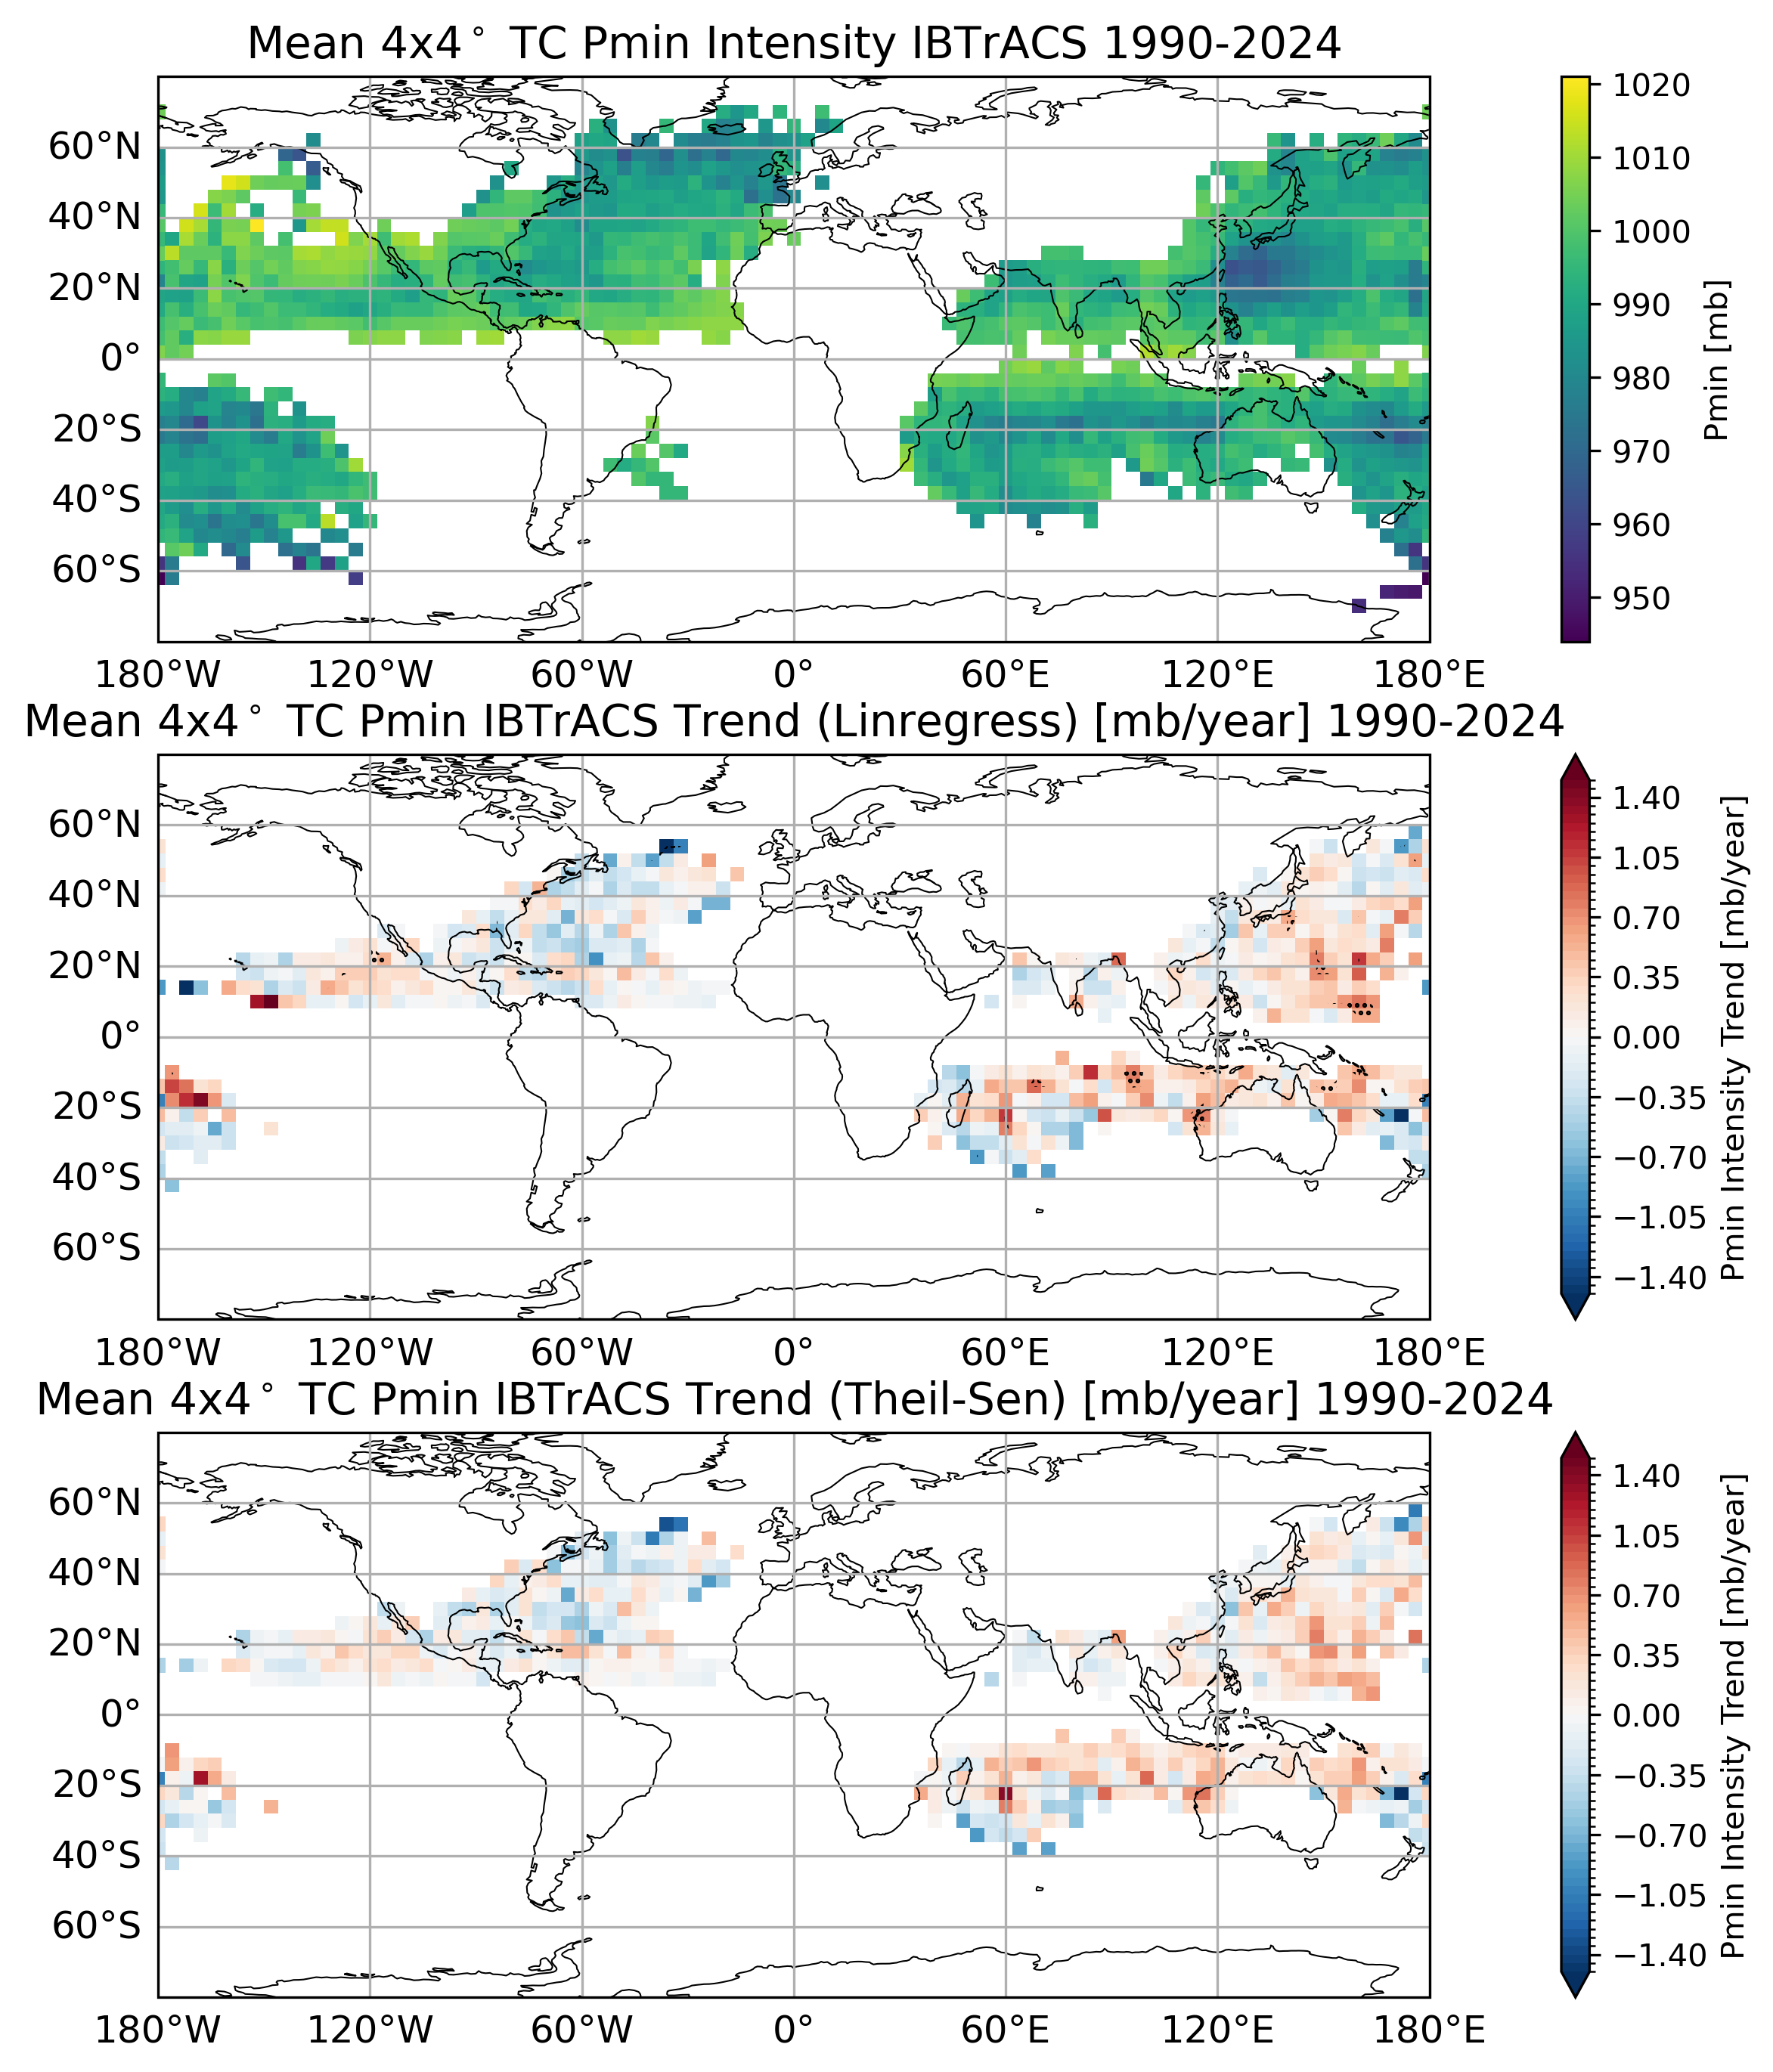

In [54]:
# spatial maps of intensity trends
if meantype == 'mean':
  tint = xr.open_dataarray(f'ibtracs-meanpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')
if meantype == 'max':
  tint = xr.open_dataarray(f'ibtracs-maxpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')


fig = plt.figure(figsize=(15,11),dpi=300,)

ax = fig.add_subplot(3,1,1,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

tint.mean('year').plot(cmap='viridis', cbar_kwargs={'label': 'Pmin [mb]'}
 #                       levels=np.arange(32,74,3.0),
                      )
plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Pmin Intensity IBTrACS {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC intensity {year0}-{year1}',fontsize=14)


ax = fig.add_subplot(3,1,2,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_grid.plot(
                levels=np.arange(-1.5,1.55,0.05), extend='both', cbar_kwargs={'label': 'Pmin Intensity Trend [mb/year]'}
               )
cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Pmin IBTrACS Trend (Linregress) [mb/year] {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Intensity Trend (Linregress) [m/s/year] {year0}-{year1}',fontsize=14)

ax = fig.add_subplot(3,1,3,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_th_grid.plot(
                levels=np.arange(-1.5,1.55,0.05), extend='both' ,cbar_kwargs={'label': 'Pmin Intensity Trend [mb/year]'}
               )
# cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Pmin IBTrACS Trend (Theil-Sen) [mb/year] {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Intensity Trend (Theil-Sen) [m/s/year] {year0}-{year1}',fontsize=14)


## Zonal Plots

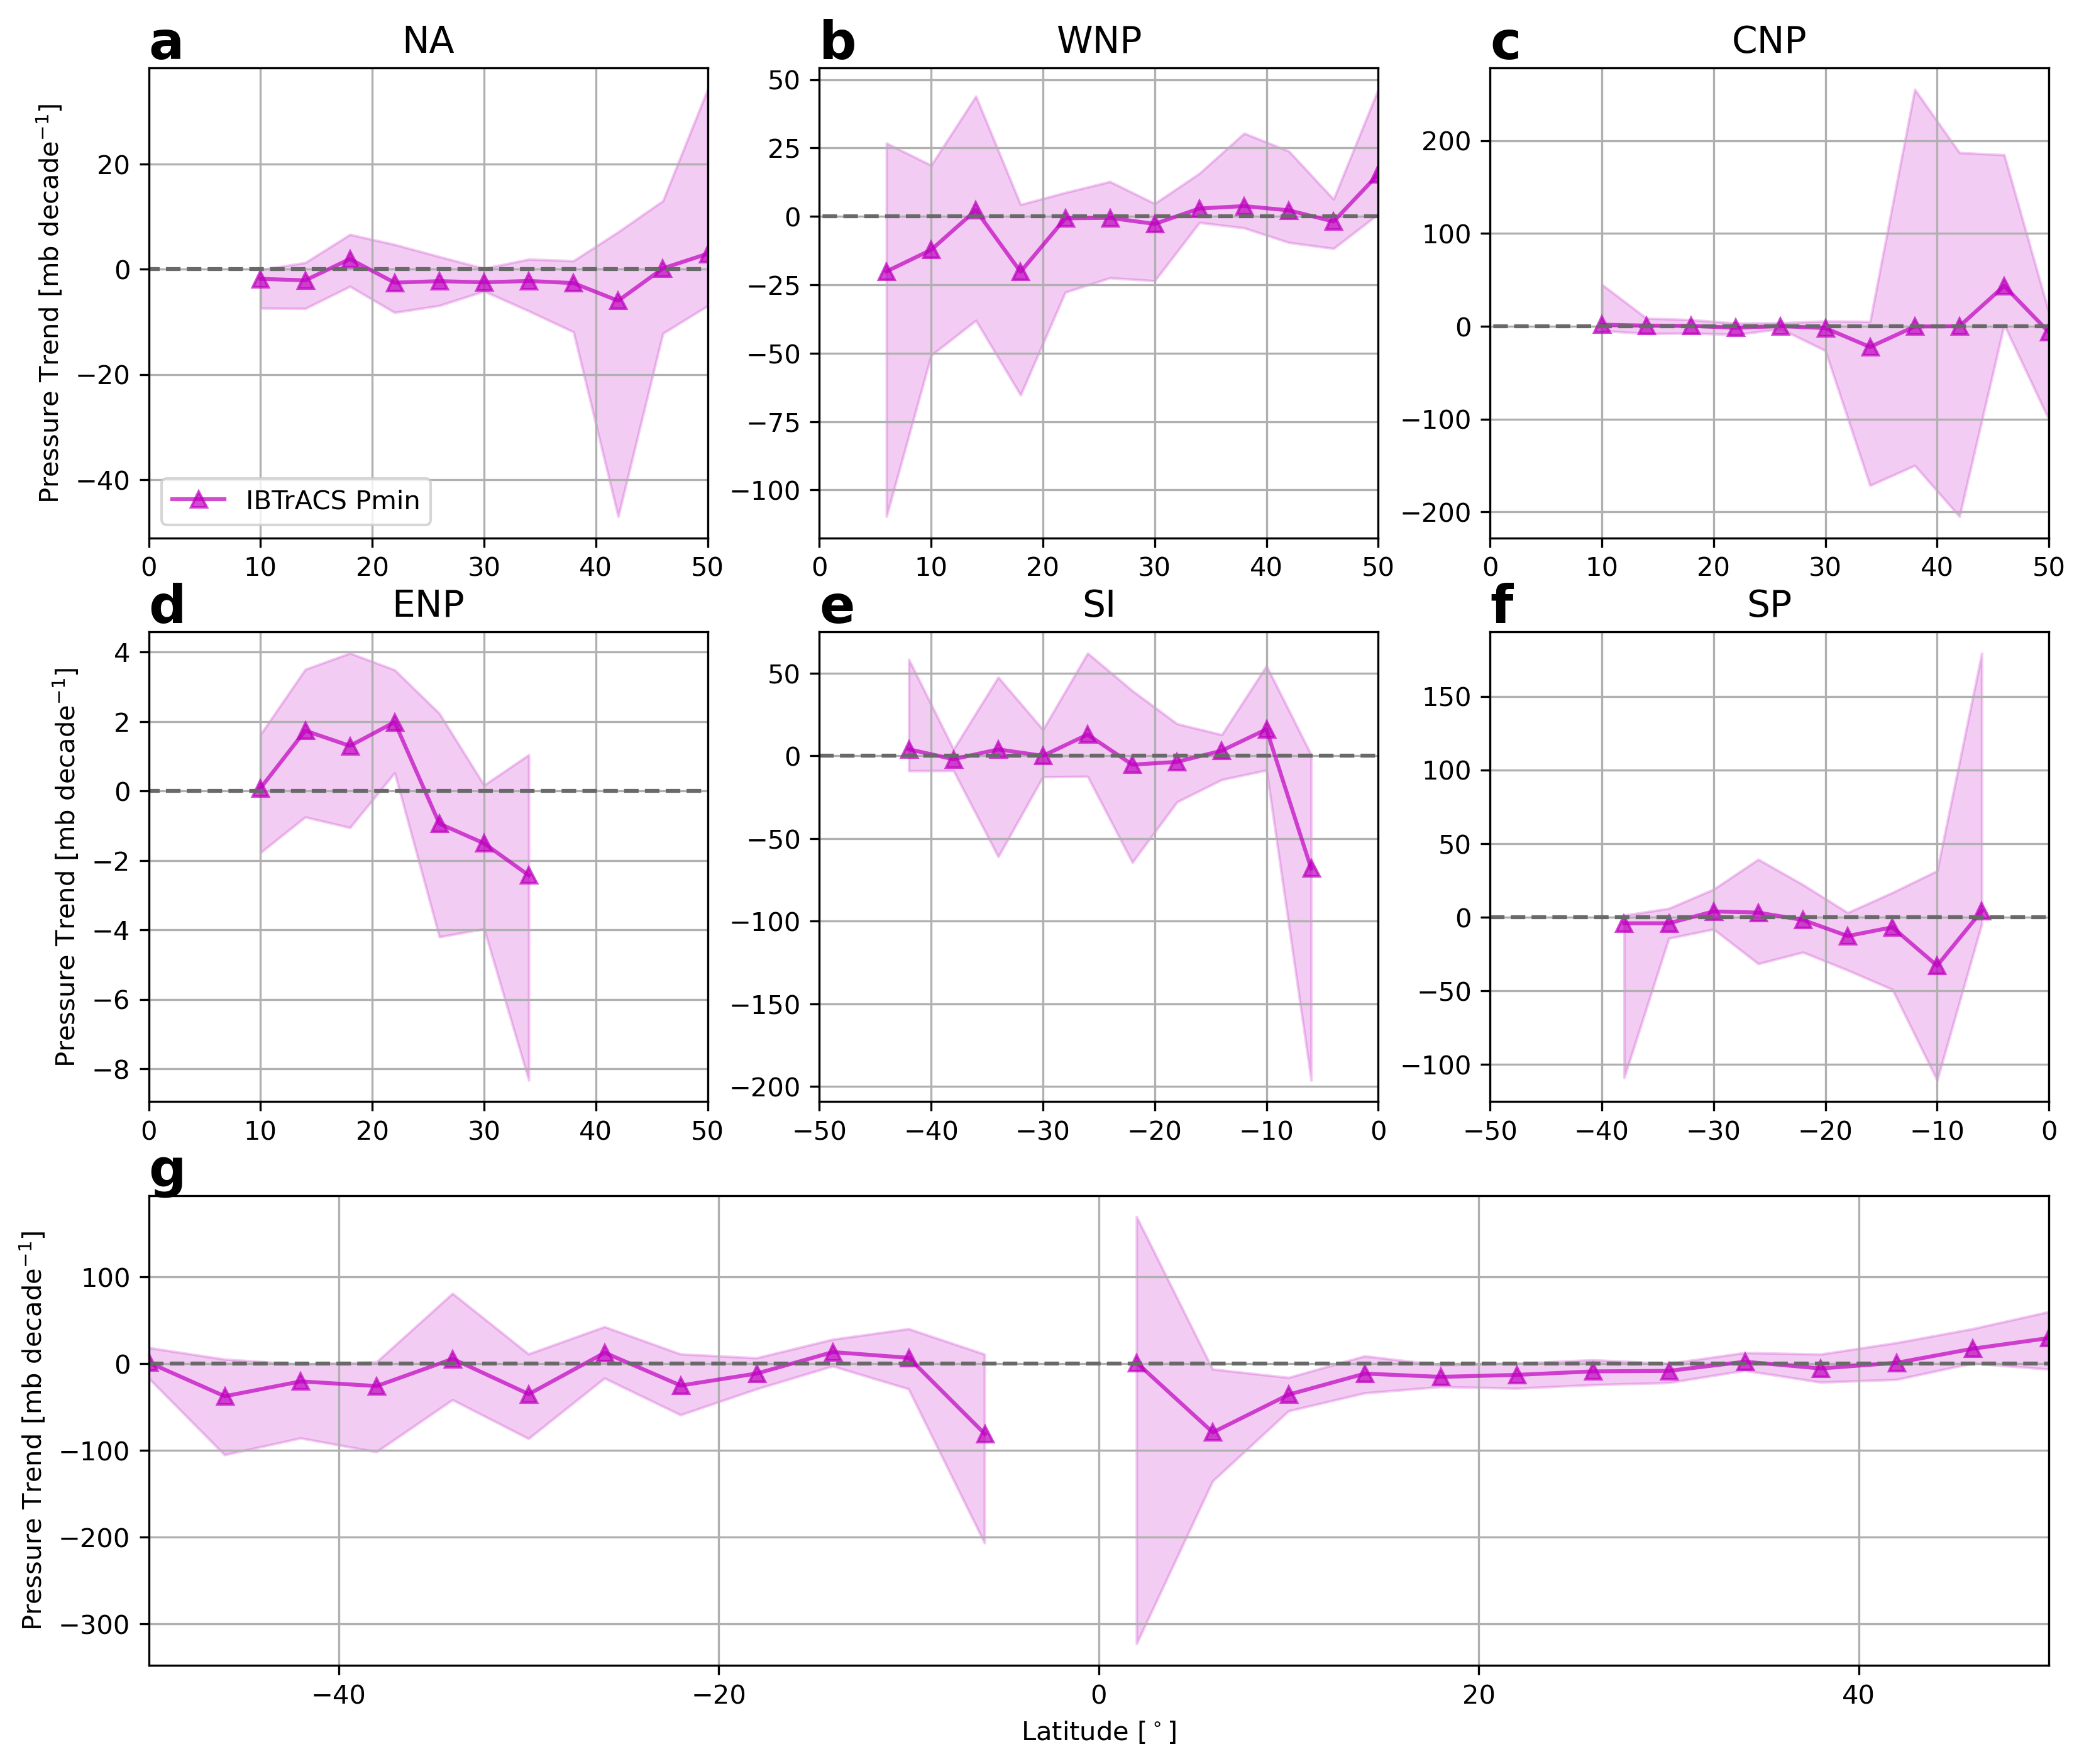

In [56]:
#fig: zonal comparison of ibtracs by basin

basin_list = ['NA','WNP','CNP','ENP','SI','SP','']

lonslice_list_cmip = [slice(266.25,308.75),slice(131.25,178.75),slice(180,230),slice(230,265.75),slice(61.25,135),
                 slice(135,178.75),slice(0,360)]
latslice_list_cmip = [slice(8.75,50),slice(3.75,50),slice(3.75,50),slice(3.75,50),slice(-50,-3.75),slice(-50,-3.75),
                 slice(-50,50)]

tint = xr.open_dataarray(f'ibtracs-meanpres-{gridsize}x{gridsize}_{year0}-{year1}.nc')
td = xr.open_dataarray(f'ibtracs-trackdensity-{gridsize}x{gridsize}_{year0}-{year1}.nc')


fig = plt.figure(figsize=(13,11),dpi=300,)
fig.set_facecolor('white')

for i in range(len(basin_list)):
    basin = basin_list[i]
    latslice2 = latslice_list_cmip[i]
    lonslice2 = lonslice_list_cmip[i]

    tint_weighted = (tint*td).sel(lat=latslice2,lon=lonslice2)
    tint_zonal = tint_weighted.mean('lon')/td.sel(lat=latslice2,lon=lonslice2).where(td>0).mean('lon')
    # tint_zonal = tint.sel(lat=latslice2,lon=lonslice2).max('lon')  #use this for max in each basin


    pval_list = []
    slope_list = []
    err_high = []
    err_low = []
    for lat in tint_zonal.lat:
            tint_grid = tint_zonal.sel(lat=lat).dropna('year')
            if len(tint_grid)<thresh:
                pval_list.append(float('nan'))
                slope_list.append(float('nan'))
                err_high.append(float('nan'))
                err_low.append(float('nan'))
                continue
            # slope,intercept,rval,pval,std_err = stats.linregress(tint_grid.year.values,tint_grid.values)
            # ci_slopelow,ci_slopehigh = get_cis(tint_grid.year.values,tint_grid.values)
            slope_th, intercept, low_slope, high_slope = stats.theilslopes(tint_grid.values,tint_grid.year.values)
            # pval_list.append(float(pval))
            slope_list.append(float(slope_th))
            # err_high.append(ci_slopehigh[0])
            # err_low.append(ci_slopelow[0])
            err_high.append(float(high_slope))
            err_low.append(float(low_slope))

    # pval_grid = xr.DataArray(np.array(pval_list).reshape(len(tint_zonal.lat)),
    #                         coords={'lat':tint_zonal.lat.values})

    slope_basin_tint = xr.DataArray(np.array(slope_list).reshape(len(tint_zonal.lat)),
                            coords={'lat':tint_zonal.lat.values})*10
    err_high_grid = xr.DataArray(np.array(err_high).reshape(len(tint_zonal.lat)),
                        coords={'lat':tint_zonal.lat.values})
    err_low_grid = xr.DataArray(np.array(err_low).reshape(len(tint_zonal.lat)),
                    coords={'lat':tint_zonal.lat.values})


    if basin!='':
        ax = fig.add_subplot(3,3,i+1)

        slope_basin_tint.plot(ax=ax,label='IBTrACS Pmin',color='m',marker='^',alpha=0.7)
        plt.fill_between(slope_basin_tint.lat,err_low_grid*10,err_high_grid*10,alpha=0.2,color='m')

        plt.legend()
        if i==0:
            ax.legend(loc='lower left')
        else:
            ax.get_legend().remove()

        ax.text(0, 1.02, string.ascii_lowercase[i], transform=ax.transAxes,
            size=20, weight='bold')
        ax.set_title(basin,fontsize=14)
        ax.grid(visible=True)
#         ax.set_ylim(-0.5,2.7)
        plt.hlines(0,-50,50,color='dimgrey',linestyle='--')
        ax.set_xlabel('')

        if i==0 or i==3:
            ax.set_ylabel('Pressure Trend [mb decade$^{-1}$]')
        else:
            ax.set_ylabel('')
        if basin!='SP' and basin!='SI':
            plt.xlim(0,50)
        else:
            plt.xlim(-50,0)
    else:
        ax = fig.add_subplot(3,1,3)


        slope_basin_tint.plot(ax=ax,label='IBTrACS Pmin',color='m',marker='^',alpha=0.7)
        plt.fill_between(slope_basin_tint.lat,err_low_grid*10,err_high_grid*10,alpha=0.2,color='m')

        plt.title('')
        ax.text(0, 1.02, string.ascii_lowercase[i], transform=ax.transAxes,
            size=20, weight='bold')
        ax.grid(visible=True)
        ax.set_xlim(-50,50)
        ax.set_ylabel('Pressure Trend [mb decade$^{-1}$]')
        #ax.set_ylim(-4,4)

        plt.hlines(0,-50,50,color='dimgrey',linestyle='--')
        ax.set_xlabel('Latitude [$^\circ$]')
        plt.title('')



## Potential Intensity Map

In [72]:
pi = xr.open_dataset("era5_monthly_PI_2x2_1979-2022.nc")

In [74]:
pi2 = xr.open_dataset("era5_monthly_PI_2x2_2023-2024.nc")

In [76]:
pi

<xarray.Dataset> Size: 68MB
Dimensions:                        (time: 528, lat: 90, lon: 180)
Coordinates:
  * time                           (time) datetime64[ns] 4kB 1979-01-01 ... 2...
    latitude                       (lat) int64 720B ...
    longitude                      (lon) int64 1kB ...
  * lat                            (lat) int64 720B -90 -88 -86 -84 ... 84 86 88
  * lon                            (lon) int64 1kB 0 2 4 6 8 ... 352 354 356 358
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 68MB ...

In [78]:
pi2

<xarray.Dataset> Size: 3MB
Dimensions:                        (time: 24, lat: 90, lon: 180)
Coordinates:
    number                         int64 8B ...
  * time                           (time) datetime64[ns] 192B 2023-01-01 ... ...
    expver                         <U4 16B ...
    latitude                       (lat) int64 720B ...
    longitude                      (lon) int64 1kB ...
  * lat                            (lat) int64 720B -90 -88 -86 -84 ... 84 86 88
  * lon                            (lon) int64 1kB 0 2 4 6 8 ... 352 354 356 358
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 3MB ...

In [82]:
print(pi['__xarray_dataarray_variable__'].isnull().sum())
print(pi2['__xarray_dataarray_variable__'].isnull().sum())

<xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(4820055)
<xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(217566)
Coordinates:
    number   int64 8B ...
    expver   <U4 16B ...


In [84]:
print(pi['time'])
print(pi2['time'])

<xarray.DataArray 'time' (time: 528)> Size: 4kB
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2022-12-01
<xarray.DataArray 'time' (time: 24)> Size: 192B
array(['2023-01-01T00:00:00.000000000', '2023-02-01T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-05-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000',
       '2023-07-01T00:00:00.000000000', '2023-08-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000', '2024-02-01T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000', '2024-04-

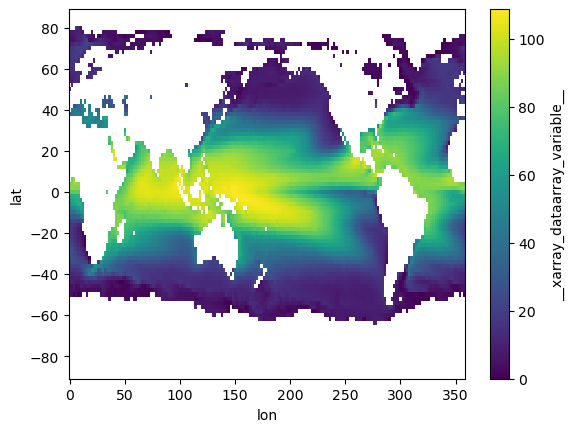

In [88]:
pi['__xarray_dataarray_variable__'].mean(dim='time').plot(cmap='viridis')

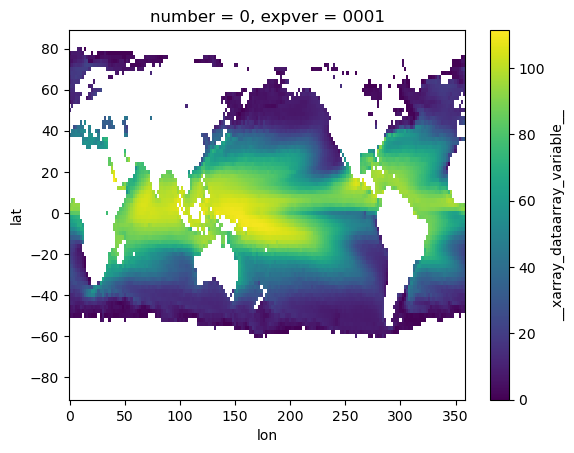

In [90]:
pi2['__xarray_dataarray_variable__'].mean(dim='time').plot(cmap='viridis')

### combining the PI into 1 file

In [48]:
# Align the datasets
pi, pi2 = xr.align(pi, pi2, join='outer')

# Concatenate along the time dimension
combined = xr.concat([pi, pi2], dim='time')

# Save the combined dataset
combined.to_netcdf("era5_monthly_PI_2x2_1979-2024.nc")

In [50]:
combined

<xarray.Dataset> Size: 143MB
Dimensions:                        (time: 1104, lat: 90, lon: 180)
Coordinates:
  * time                           (time) datetime64[ns] 9kB 1979-01-01 ... 2...
  * lat                            (lat) int64 720B -90 -88 -86 -84 ... 84 86 88
  * lon                            (lon) int64 1kB 0 2 4 6 8 ... 352 354 356 358
    latitude                       (lat) int64 720B -90 -88 -86 -84 ... 84 86 88
    longitude                      (lon) int64 1kB 0 2 4 6 8 ... 352 354 356 358
    number                         int64 8B ...
    expver                         <U4 16B ...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 143MB nan ... nan

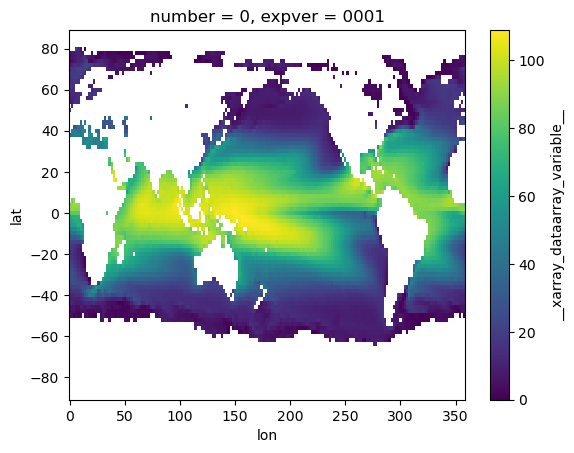

In [92]:
combined['__xarray_dataarray_variable__'].mean(dim='time').plot(cmap='viridis')

### dividing it by grids and plotting the mean 

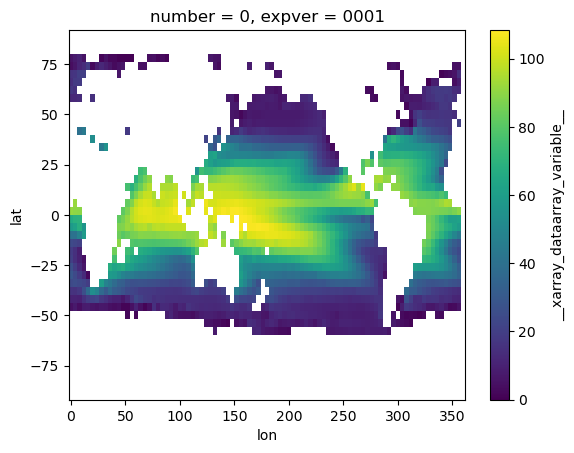

In [112]:
combined['__xarray_dataarray_variable__'].mean(dim='time').interp(lat=range(-90, 91, 4), lon=range(0, 361, 4), method='linear').plot(cmap='viridis')

In [135]:
track_year

<xarray.Dataset> Size: 11MB
Dimensions:           (index: 8090)
Coordinates:
  * index             (index) int64 65kB 62712 62713 62714 ... 75224 75225 75226
Data variables: (12/174)
    SID               (index) object 65kB '1989189S07088' ... '1990348N04087'
    SEASON            (index) object 65kB 1990 1990 1990 1990 ... 1990 1990 1990
    NUMBER            (index) object 65kB 49 49 49 49 49 ... 116 116 116 116 116
    BASIN             (index) object 65kB 'SI' 'SI' 'SI' 'SI' ... 'NI' 'NI' 'NI'
    SUBBASIN          (index) object 65kB 'MM' 'MM' 'MM' 'MM' ... 'BB' 'BB' 'BB'
    NAME              (index) object 65kB 'UNNAMED' 'UNNAMED' ... 'UNNAMED'
    ...                ...
    USA_SEARAD_NE     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SE     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SW     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_NW     (index) object 65kB ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    STORM_SPEED       (index) object 65kB '6' '6' '6' '5' '4' '3' ... 9 10 9 9 9
    STORM_DIR         (index) object 65kB '305' '300' '290' '280' ... 65 70 75

### Creating the ratio intensity file

In [22]:
combined = xr.open_dataset('era5_monthly_PI_2x2_1979-2024.nc')

In [24]:
# Remove duplicates in the time dimension, if any
combined = combined.drop_duplicates(dim='time')

In [26]:
# Regrid PI to 4x4 degree grid while preserving time dimension
pi_gridded = combined['__xarray_dataarray_variable__'].interp(
    lat=range(-90, 91, 4),
    lon=range(0, 361, 4),
    method='linear'
)

In [28]:
st = time.time()

tint_list = []

for year in np.arange(year0, year1 + 1):
    # Filter by year and convert to xarray, setting ISO_TIME as the time dimension
    track_year = ib_df[ib_df.SEASON == year]
    track_year = track_year.set_index('ISO_TIME').to_xarray()

    gridsize = n
    td_list = []
    # Iterate over the ISO_TIME dimension
    for i in range(len(track_year.ISO_TIME)):
        grid = np.zeros((int(180 / gridsize), int(360 / gridsize)))
        track_point = track_year.isel(ISO_TIME=i)
        lon = track_point.LON.values
        if lon < 0:
            lon += 360  # Convert -180 to 180 to 0 to 360
        lon_g = round(lon / gridsize)
        lat_g = round((track_point.LAT.values + 90) / gridsize)

        # Add bounds checking
        lat_g = np.clip(lat_g, 0, int(180 / gridsize) - 1)  # 0 to 45
        lon_g = np.clip(lon_g, 0, int(360 / gridsize) - 1)  # 0 to 90

        intensity = track_point.WMO_WIND
        if intensity == ' ':
            intensity = float('NaN')
        else:
            intensity = float(intensity) * 0.514444  # Convert string to float (m/s)

            # Get the timestamp from ISO_TIME and extract year/month
            track_time = pd.to_datetime(track_point.ISO_TIME.values)
            year_month = f"{track_time.year}-{track_time.month:02d}-01"

            # Select the PI for the corresponding month from the gridded data
            pi_monthly = pi_gridded.sel(time=year_month)
            pi_at_point = pi_monthly.values[lat_g, lon_g]

            # Compute the ratio (WMO_WIND / PI)
            if not np.isnan(pi_at_point) and pi_at_point != 0:  # Avoid division by zero
                ratio = pi_at_point # changing this to just pi if needed change it back to ratio
            else:
                ratio = float('NaN')

            grid[lat_g, lon_g] = ratio  # Store the ratio in the grid

        td = xr.DataArray(grid, dims=('lat', 'lon'))
        td.coords['lat'] = (td.coords['lat'] * gridsize - 90)
        td.coords['lon'] = (td.coords['lon'] * gridsize)
        td_list.append(td)

    tint_year = xr.concat((a for a in td_list), 'point')
    if meantype == 'max':
        tint_year = tint_year.where(tint_year > 0).max('point').assign_coords(year=year)
    elif meantype == 'mean':
        tint_year = tint_year.where(tint_year > 0).mean('point').assign_coords(year=year)

    tint_list.append(tint_year)

    et = time.time()
    print(f'{year}: {round((et - st) / 60, 3)} mins')

# Save the output to NetCDF
if meantype == 'max':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-maxpi-{gridsize}x{gridsize}_{year0}-{year1}.nc')
elif meantype == 'mean':
    xr.concat((a for a in tint_list), 'year').to_netcdf(f'ibtracs-meanpi-{gridsize}x{gridsize}_{year0}-{year1}.nc')

1990: 1.489 mins
1991: 2.677 mins
1992: 4.207 mins
1993: 5.451 mins
1994: 6.938 mins
1995: 8.135 mins
1996: 9.664 mins
1997: 11.34 mins
1998: 12.532 mins
1999: 13.682 mins
2000: 14.908 mins
2001: 15.963 mins
2002: 17.005 mins
2003: 18.111 mins
2004: 19.246 mins
2005: 20.613 mins
2006: 21.74 mins
2007: 22.72 mins
2008: 23.868 mins
2009: 24.934 mins
2010: 25.887 mins
2011: 26.965 mins
2012: 28.087 mins
2013: 29.176 mins
2014: 30.356 mins
2015: 31.682 mins
2016: 32.81 mins
2017: 33.858 mins
2018: 35.231 mins
2019: 36.564 mins
2020: 37.696 mins
2021: 38.925 mins
2022: 39.989 mins
2023: 41.202 mins
2024: 42.099 mins


In [30]:
# calculates intensity trends for spatial maps

st = time.time()

if meantype == 'max':
  tint = xr.open_dataarray(f'ibtracs-maxpi-{gridsize}x{gridsize}_{year0}-{year1}.nc')
elif meantype == 'mean':
  tint = xr.open_dataarray(f'ibtracs-meanpi-{gridsize}x{gridsize}_{year0}-{year1}.nc')


pval_list = []
slope_list = []
slope_th_list = []
slope_high_list = []
slope_low_list = []

for lat in tint.lat:
    for lon in tint.lon:
        tint_grid = tint.sel(lat=lat,lon=lon).dropna('year')
        if len(tint_grid)<thresh:
            pval_list.append(float('nan'))
            slope_list.append(float('nan'))
            slope_th_list.append(float('nan'))
            slope_low_list.append(float('nan'))
            slope_high_list.append(float('nan'))
            continue
        slope,intercept,rval,pval,std_err = stats.linregress(tint_grid.year.values,tint_grid.values)
        slope_th, intercept, low_slope, high_slope = stats.theilslopes(tint_grid.values,tint_grid.year.values)

        pval_list.append(float(pval))
        slope_list.append(float(slope))
        slope_th_list.append(float(slope_th))
        slope_high_list.append(float(high_slope))
        slope_low_list.append(float(low_slope))

pval_grid = xr.DataArray(np.array(pval_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})

slope_grid = xr.DataArray(np.array(slope_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})
slope_th_grid = xr.DataArray(np.array(slope_th_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})
slope_high_grid = xr.DataArray(np.array(slope_high_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})
slope_low_grid = xr.DataArray(np.array(slope_low_list).reshape(len(tint.lat),len(tint.lon)),
                        coords={'lat':tint.lat.values,'lon':tint.lon.values})


et = time.time()
elapsed_time = et - st
print(elapsed_time/60, 'mins')

0.2669994592666626 mins


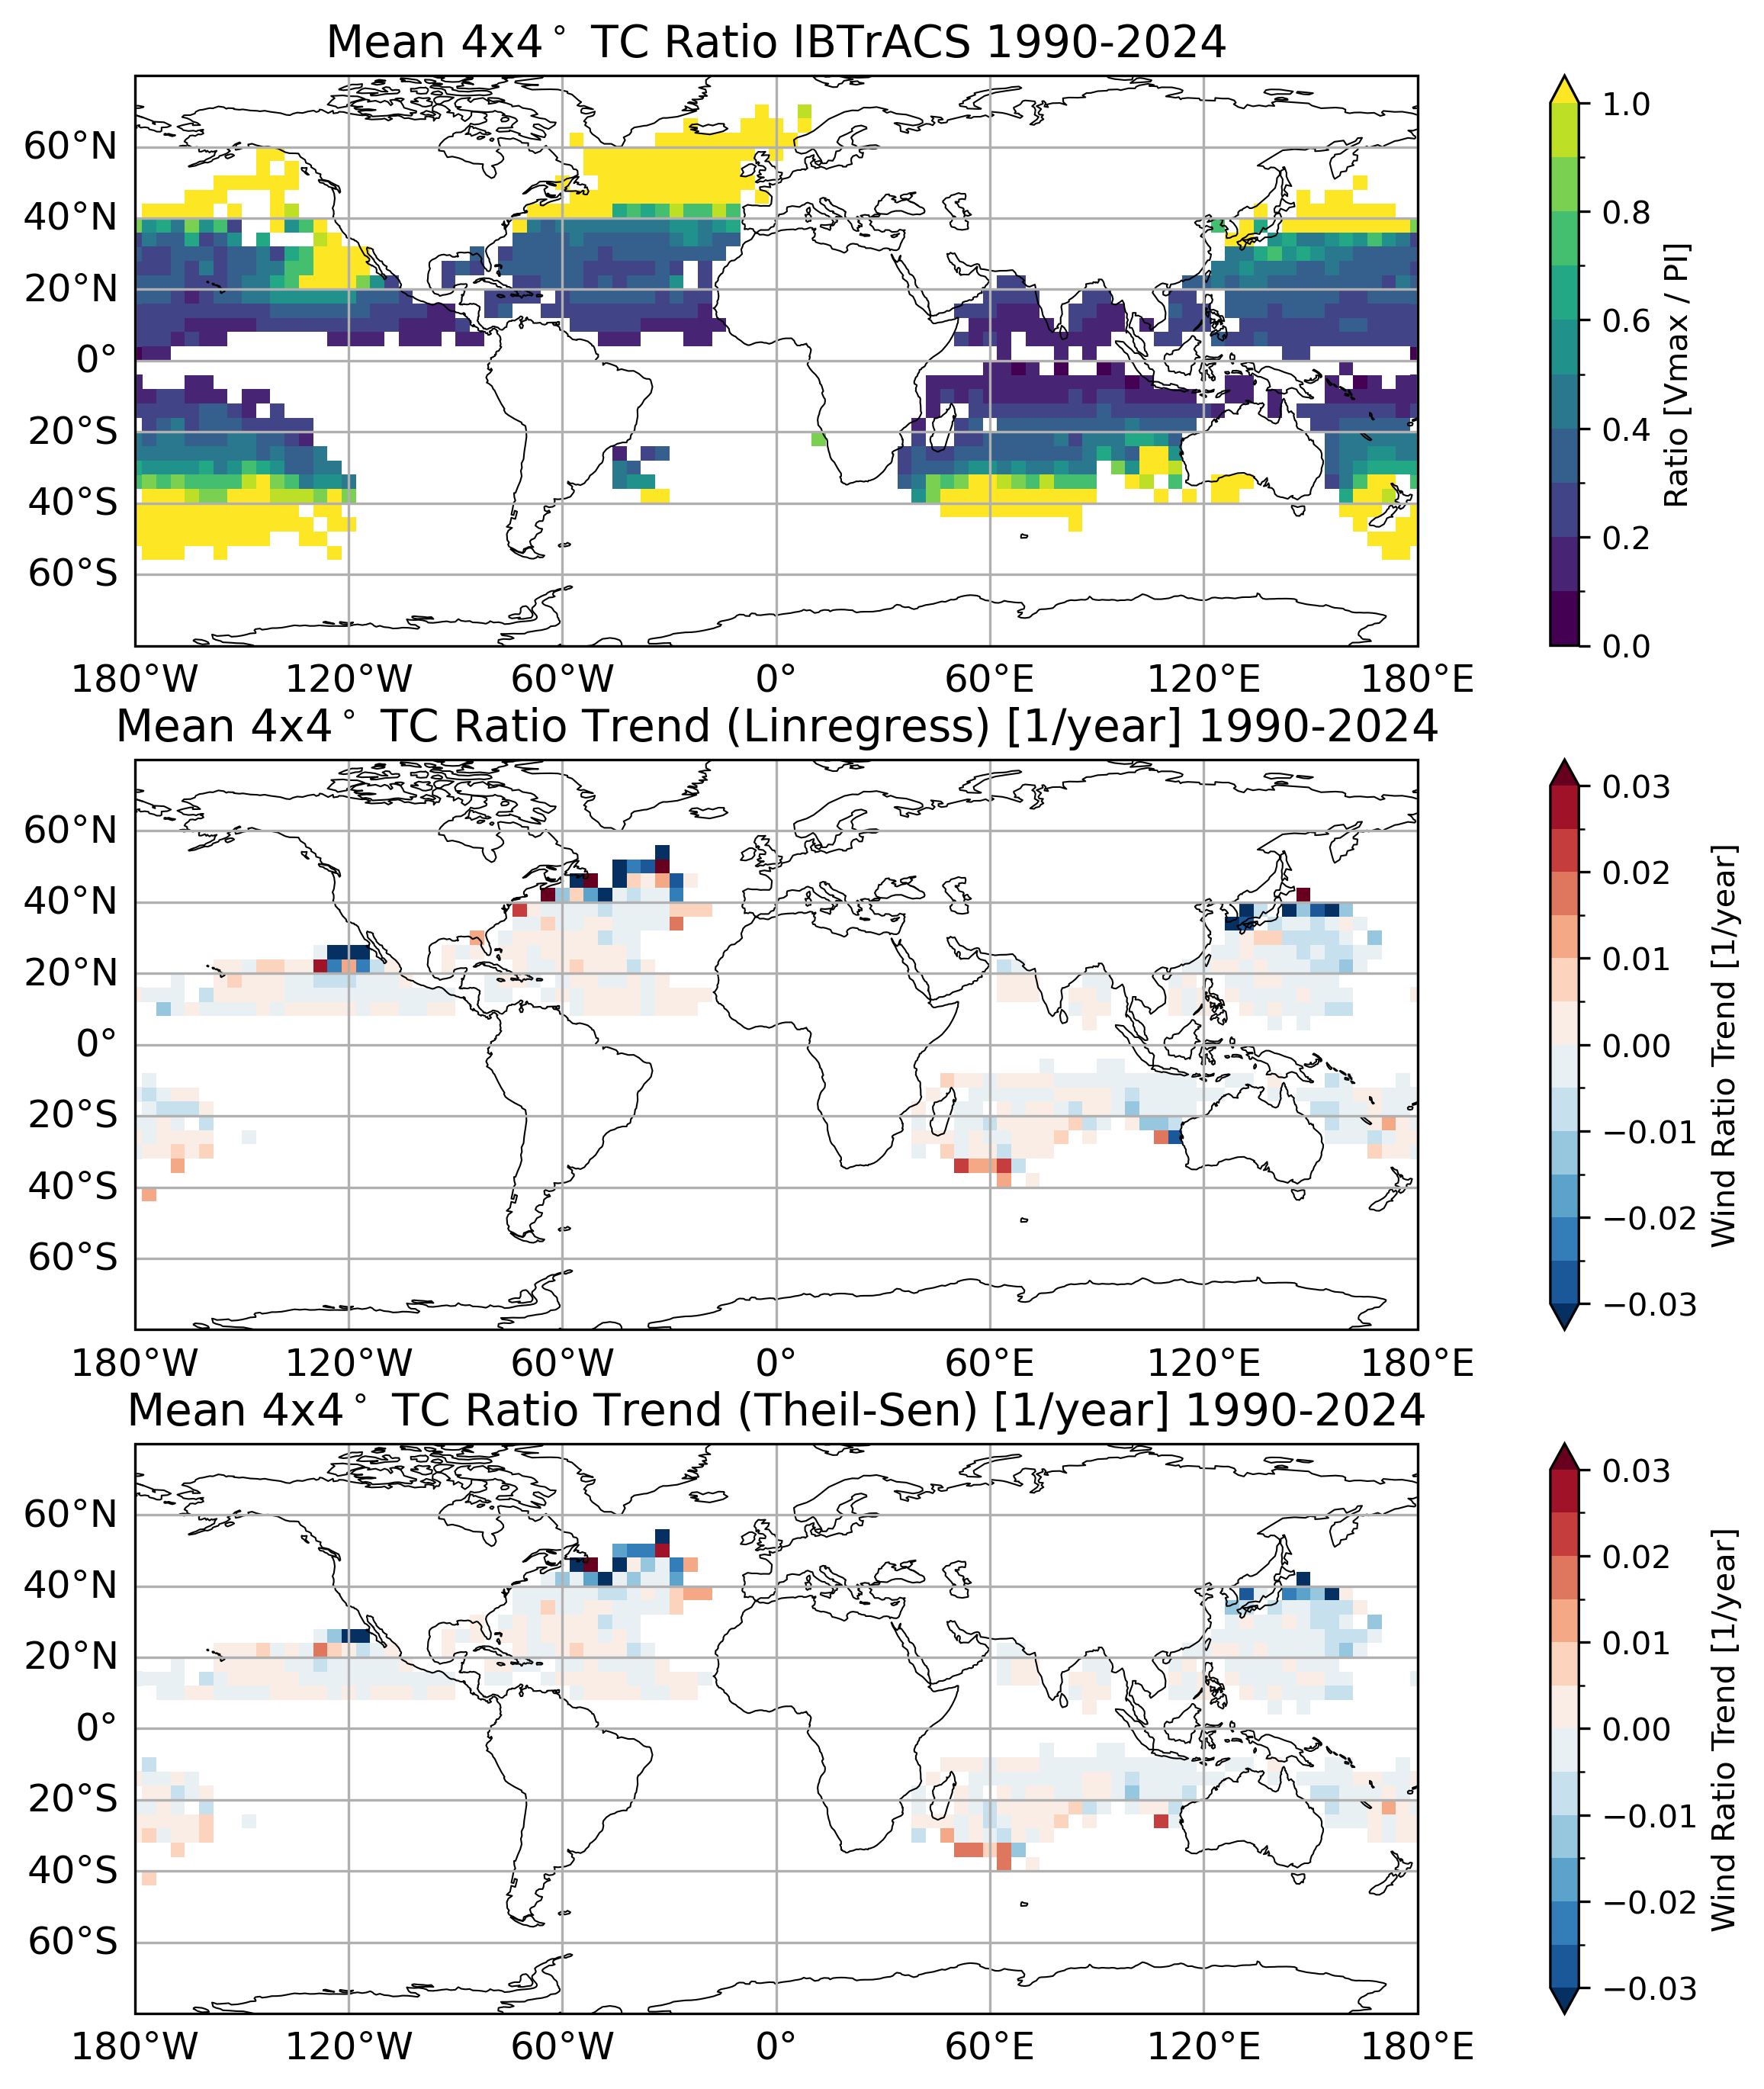

In [40]:
# spatial maps of intensity trends
if meantype == 'mean':
  tint = xr.open_dataarray(f'ibtracs-meanratio-{gridsize}x{gridsize}_{year0}-{year1}.nc')
if meantype == 'max':
  tint = xr.open_dataarray(f'ibtracs-maxratio-{gridsize}x{gridsize}_{year0}-{year1}.nc')


fig = plt.figure(figsize=(15,11),dpi=300,)

ax = fig.add_subplot(3,1,1,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

tint.mean('year').plot(cmap='viridis', cbar_kwargs={'label': 'Ratio [Vmax / PI]'},
                       levels=np.arange(0,1.1,0.1), extend='max'
                      )
plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Ratio IBTrACS {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Ratio {year0}-{year1}',fontsize=14)


ax = fig.add_subplot(3,1,2,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_grid.plot(
                levels=np.arange(-0.03,0.035,0.005), 
    extend='both', cbar_kwargs={'label': 'Wind Ratio Trend [1/year]'}
               )
#cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Ratio Trend (Linregress) [1/year] {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Ratio Trend (Linregress) [1/year] {year0}-{year1}',fontsize=14)

ax = fig.add_subplot(3,1,3,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_th_grid.plot(
                levels=np.arange(-0.03,0.035,0.005), 
    extend='both' ,cbar_kwargs={'label': 'Wind Ratio Trend [1/year]'}
               )
#cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC Ratio Trend (Theil-Sen) [1/year] {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC Ratio Trend (Theil-Sen) [1/year] {year0}-{year1}',fontsize=14)


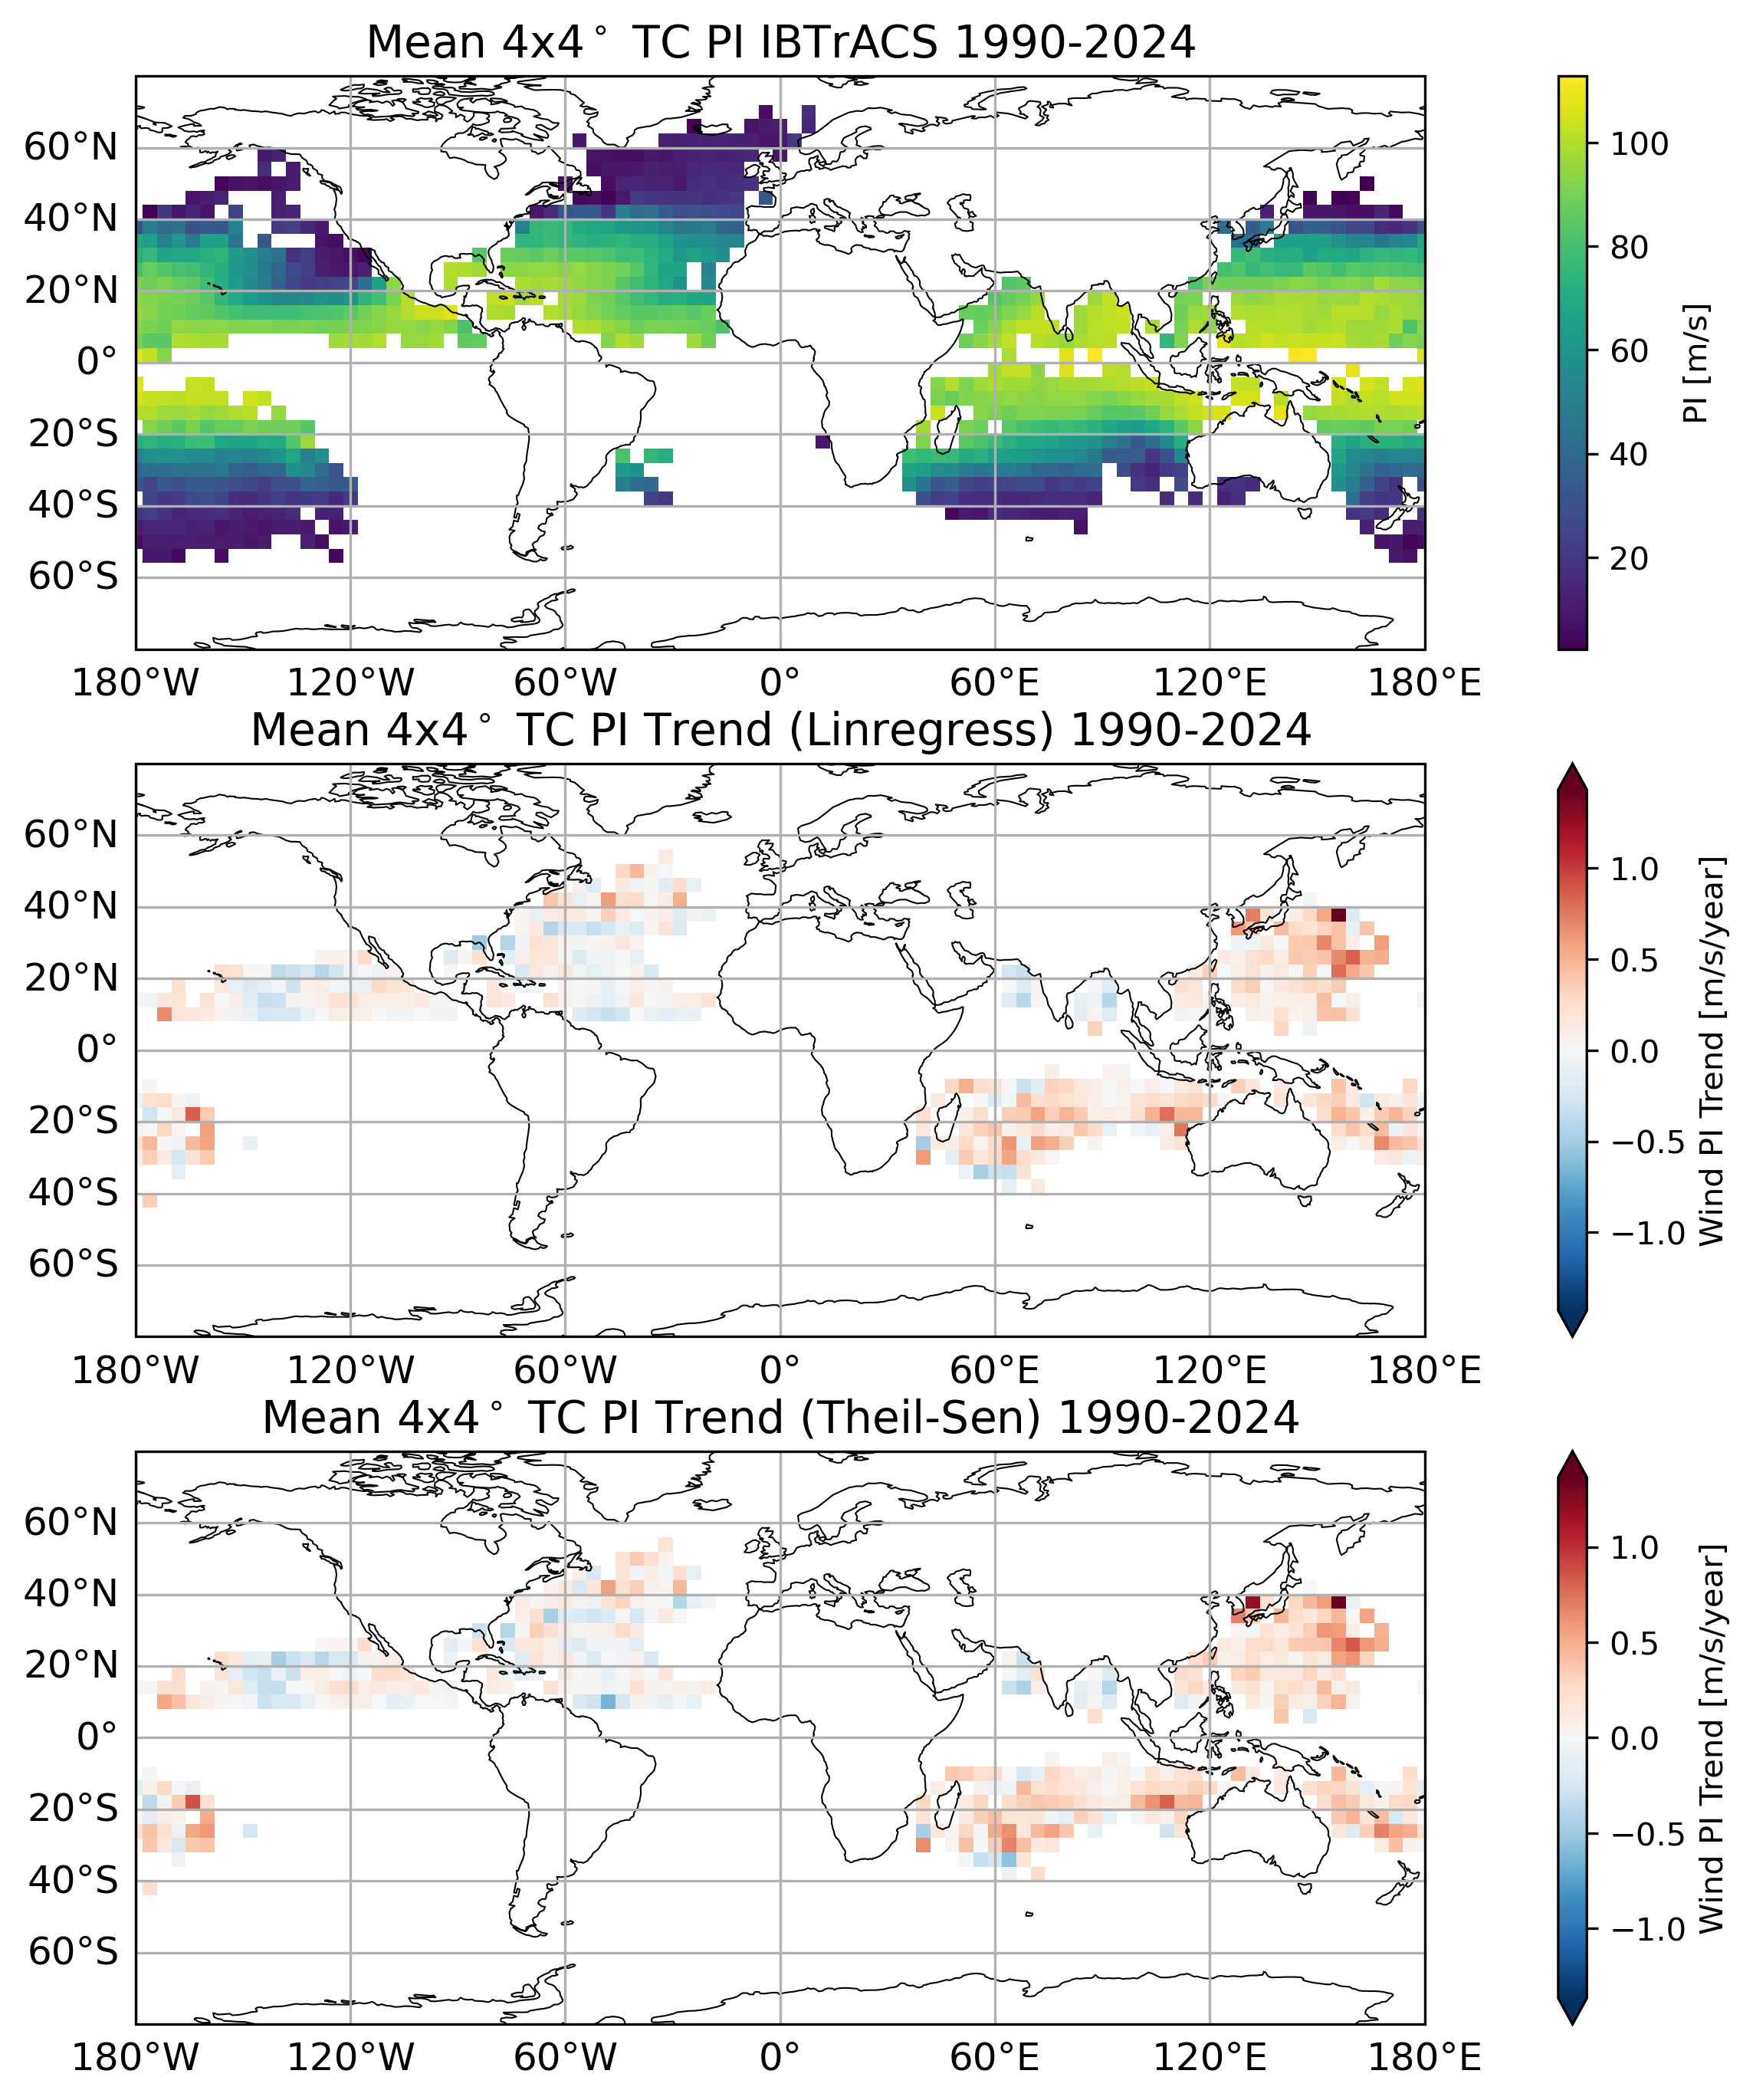

In [36]:
# spatial maps of intensity trends
if meantype == 'mean':
  tint = xr.open_dataarray(f'ibtracs-meanpi-{gridsize}x{gridsize}_{year0}-{year1}.nc')
if meantype == 'max':
  tint = xr.open_dataarray(f'ibtracs-maxpi-{gridsize}x{gridsize}_{year0}-{year1}.nc')


fig = plt.figure(figsize=(15,11),dpi=300,)

ax = fig.add_subplot(3,1,1,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

tint.mean('year').plot(cmap='viridis', cbar_kwargs={'label': 'PI [m/s]'},
                       #levels=np.arange(0,1.1,0.1), extend='max'
                      )
plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC PI IBTrACS {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC PI {year0}-{year1}',fontsize=14)


ax = fig.add_subplot(3,1,2,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_grid.plot(
                #levels=np.arange(-0.03,0.035,0.005), 
    extend='both', cbar_kwargs={'label': 'Wind PI Trend [m/s/year]'}
               )
#cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC PI Trend (Linregress) {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC PI Trend (Linregress) {year0}-{year1}',fontsize=14)

ax = fig.add_subplot(3,1,3,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', zorder=2)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.top_labels = False
gl.right_labels = False
gl.xlines = gl.ylines = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

slope_th_grid.plot(
                #levels=np.arange(-0.03,0.035,0.005), 
    extend='both' ,cbar_kwargs={'label': 'Wind PI Trend [m/s/year]'}
               )
#cntr = pval_grid.plot.contourf(levels =[0.00, 0.05], hatches=['.....',None],colors='none',add_colorbar=False)


plt.ylim(-80,80)
if meantype == 'mean':
  plt.title(f'Mean {gridsize}x{gridsize}$^\circ$ TC PI Trend (Theil-Sen) {year0}-{year1}',fontsize=14)
if meantype == 'max':
  plt.title(f'Mean max. {gridsize}x{gridsize}$^\circ$ TC PI Trend (Theil-Sen) {year0}-{year1}',fontsize=14)
